## 2019-07-14: Using Interpolation to Standardize Spectra

### Authors
* Kevin Chu (kevin@velexi.com)

### Notes
* The format of spectra data (e.g., sampling resolution and ranges) contained in USGS Spectral Library Version 7 Data (splib07) varies depending on the spectrometer used to collect the data.

* In this Jupyter notebook, we investigate using linear interpolation to standardize the spectra data across spectrometers.

* __Recommendation__: standarize spectra only across spectrometers that operate in similar wavelength/wavenumber ranges. For instance, we do not recommend standardizing spectra between Beckman (wavelength range: 0.2 to 3 microns) and Nicolet (wavelength: 1 to 216 microns).

## Preparations

In [1]:
# --- Imports

# Standard libraries
import os

# External packages
import matplotlib.pyplot as plt
import numpy
import pandas

In [2]:
# --- Configuration Parameters

# Data directory
data_dir = os.environ['DATA_DIR']
splib07a_dir = os.path.join(data_dir, 'ASCIIdata_splib07a')

# Spectrometers
spectrometers = {
    'ASDFR':
        {'description': 'Standard-resolution ASD field portable spectrometer',
         'abscissas_file': 'splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt',
         'bandpass_file': 'splib07a_Bandpass_(FWHM)_ASDFR_StandardResolution.txt',
         'abscissa_type': 'wavelength',
         'abscissa_units': 'microns',
         'abscissa_min': 0.35,
         'abscissa_max': 2.5,
         },
    'ASDHR':
        {'description': 'High-resolution ASD field portable spectrometer',
         'abscissas_file': 'splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt',
         'bandpass_file': 'splib07a_Bandpass_(FWHM)_ASDHR_High-Resolution.txt',
         'abscissa_type': 'wavelength',
         'abscissa_units': 'microns',
         'abscissa_min': 0.35,
         'abscissa_max': 2.5,
         },
    'ASDNG':
        {'description': 'High-resolution Next-Generation ASD field portable spectrometer',
         'abscissas_file': 'splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt',
         'bandpass_file': 'splib07a_Bandpass_(FWHM)_ASDNG_High-Res_NextGen.txt',
         'abscissa_type': 'wavelength',
         'abscissa_units': 'microns',
         'abscissa_min': 0.35,
         'abscissa_max': 2.5,
         },
    'AVIRIS':
        {'description': 'NASA Airborne Visible/Infra-Red Imaging Spectrometer AVIRIS',
         'abscissas_file': 'splib07a_Wavelengths_AVIRIS_1996_0.37-2.5_microns.txt',
         'bandpass_file': 'splib07a_Bandpass_(FWHM)_AVIRIS_1996_in_microns.txt',
         'abscissa_type': 'wavelength',
         'abscissa_units': 'microns',
         'abscissa_min': 0.37,
         'abscissa_max': 2.5,
         },
    'BECK':
        {'description': 'Beckman 5270',
         'abscissas_file': 'splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt',
         'bandpass_file': 'splib07a_Bandpass_(FWHM)_BECK_Beckman_in_microns.txt',
         'abscissa_type': 'wavelength',
         'abscissa_units': 'microns',
         'abscissa_min': 0.2,
         'abscissa_max': 3.0,
         },
}

# Test Spectra
test_spectra = {
    'ASDFR':
        {'path': os.path.join('ChapterM_Minerals', 'splib07a_Stilbite_HS482.1B_Zeolite_ASDFRb_AREF.txt'),
         },
    'ASDHR':
        {'path': os.path.join('ChapterM_Minerals', 'splib07a_Karpatite_GDS978_ASDHRb_AREF.txt'),
         },
    'ASDNG':
        {'path': os.path.join('ChapterM_Minerals', 'splib07a_Topaz_HS184.1B_ASDNGb_AREF.txt'),
         },
    'AVIRIS':
        {'path': os.path.join('ChapterV_Vegetation', 'splib07a_Willow_YNP-WI-1_AVIRISb_RTGC.txt'),
         },
    'BECK':
        {'path': os.path.join('ChapterM_Minerals', 'splib07a_Actinolite_HS116.3B_BECKb_AREF.txt'),
         },
}

# Spectra Standardization Parameters
abscissa_type = 'wavelength'
num_abscissas = 1000
min_abscissa = min([spectrometer['abscissa_min']
                    for spectrometer in spectrometers.values()
                    if spectrometer['abscissa_type'] == abscissa_type])
max_abscissa = max([spectrometer['abscissa_max']
                    for spectrometer in spectrometers.values()
                    if spectrometer['abscissa_type'] == abscissa_type])
target_abscissas = numpy.linspace(min_abscissa, max_abscissa, num_abscissas)

### Data Preparation

In [3]:
# --- Load spectrometer abscissas

for metadata in spectrometers.values():
    metadata['abscissas'] = pandas.read_csv(
        os.path.join(splib07a_dir, metadata['abscissas_file'])).values.flatten()

# --- Load raw test spectra data

for spectra_data in test_spectra.values():
    raw_data = pandas.read_csv(
        os.path.join(splib07a_dir, spectra_data['path']))
    raw_data[raw_data < 0] = 0.0
    spectra_data['raw_data'] = raw_data.values.flatten()

## Data Exploration

In [4]:
for spectrometer, metadata in spectrometers.items():
    print('code={},'.format(spectrometer),
          'type={},'.format(metadata['abscissa_type']),
          'units={},'.format(metadata['abscissa_units']),
          'range=({}, {})'.format(metadata['abscissa_min'], metadata['abscissa_max']),
         )

code=ASDFR, type=wavelength, units=microns, range=(0.35, 2.5)
code=ASDHR, type=wavelength, units=microns, range=(0.35, 2.5)
code=ASDNG, type=wavelength, units=microns, range=(0.35, 2.5)
code=AVIRIS, type=wavelength, units=microns, range=(0.37, 2.5)
code=BECK, type=wavelength, units=microns, range=(0.2, 3.0)


## Spectra Standardization

In [5]:
for spectrometer in spectrometers:
    spectrometer_abscissas = spectrometers[spectrometer]['abscissas']
    raw_spectra = test_spectra[spectrometer]['raw_data']
    test_spectra[spectrometer]['standardized_data'] = \
        numpy.interp(target_abscissas, spectrometer_abscissas, raw_spectra)

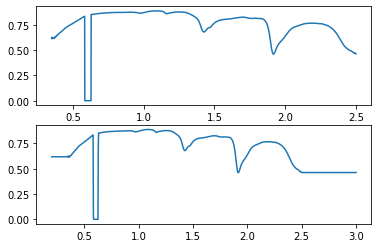

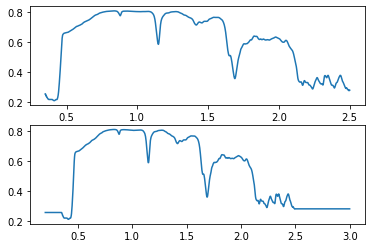

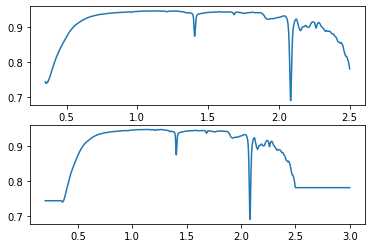

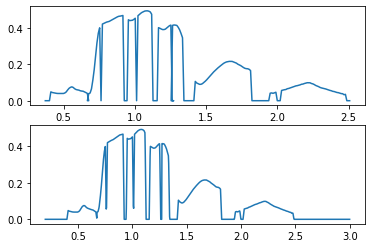

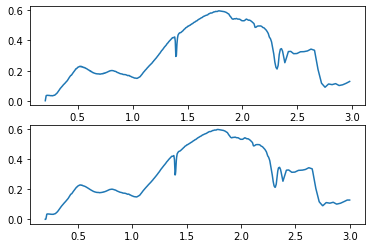

In [6]:
# Plot original and standardized spectra

for spectrometer in spectrometers:
    # Get spectra data
    spectrometer_abscissas = spectrometers[spectrometer]['abscissas']
    raw_spectra = test_spectra[spectrometer]['raw_data']
    standardized_spectra = test_spectra[spectrometer]['standardized_data']

    # Plot spectra
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(spectrometer_abscissas, raw_spectra)
    plt.subplot(2, 1, 2)
    plt.plot(target_abscissas, standardized_spectra)